In [1]:
import time
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from flask import Flask,request
import pickle

In [2]:
def load_df(csv_path, nrows = None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters = {col: json.loads for col in json_cols},                                                                         
                         dtype = {'fullVisitorId': 'str'}, # Important!!
                         nrows = nrows)
    for col in json_cols:
        # for each column, flatten data frame such that the values of a single col are spread in different cols
        # This will use subcol as names of flat_col.columns
        flat_col = json_normalize(df[col])
        # Name the columns in this flatten data frame as col.subcol for tracability
        flat_col.columns = [f"{col}.{subcol}" for subcol in flat_col.columns]
        # Drop the json_col and instead add the new flat_col
        df = df.drop(col, axis = 1).merge(flat_col, right_index = True, left_index = True)
    return df

In [3]:
%%time
train = load_df('../input/ga-customer-revenue-prediction/train_v2.csv', nrows = 120000)
test = load_df('../input/ga-customer-revenue-prediction/test_v2.csv', nrows = None)
train.shape, test.shape

CPU times: user 2min 1s, sys: 23.1 s, total: 2min 24s
Wall time: 3min 57s


((120000, 60), (401589, 59))

In [4]:
train.iloc[:,18:]

,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Central America,Mexico,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,France,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119996,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119997,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Europe,Western Europe,Germany,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119998,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train['totals.transactionRevenue'].dtype

dtype('O')

In [6]:
train['totals.transactionRevenue']=train['totals.transactionRevenue'].astype('float')

In [7]:
target=train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
cus_rev=target[target['totals.transactionRevenue']>0]

In [8]:
print('percentage of customers who generate revenue: ',round((cus_rev.shape[0])*100/target.shape[0],2))

percentage of customers who generate revenue:  1.11


<AxesSubplot:xlabel='device.operatingSystem', ylabel='count'>

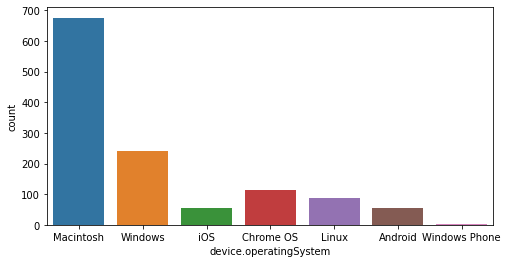

In [9]:
trans_rev=train[train['totals.transactionRevenue']>0]
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(trans_rev['device.operatingSystem'],ax=ax)

<AxesSubplot:xlabel='geoNetwork.continent', ylabel='count'>

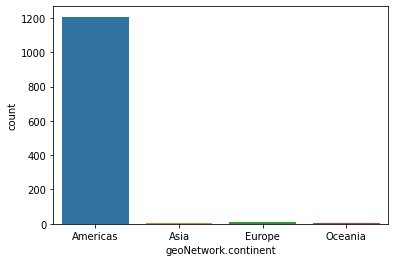

In [10]:
sns.countplot(trans_rev['geoNetwork.continent'])

In [11]:
missing_val = pd.DataFrame()
cols=train.columns
for col in cols:
    na_count = train[col].isna().sum()
    if na_count != 0:
        missing_val.loc[col, 'NaN_val(%)'] = na_count/len(train)*100
print('Number of columns with missing values in train set:', len(missing_val))
missing_val.sort_values('NaN_val(%)', inplace = True)
missing_val

Number of columns with missing values in train set: 18


,NaN_val(%)
totals.pageviews,0.010000
totals.newVisits,23.768333
totals.bounces,49.532500
totals.timeOnSite,50.611667
totals.sessionQualityDim,54.761667
trafficSource.keyword,66.640000
trafficSource.referralPath,67.336667
trafficSource.isTrueDirect,69.450833
trafficSource.adwordsClickInfo.gclId,94.719167
trafficSource.adwordsClickInfo.isVideoAd,94.763333


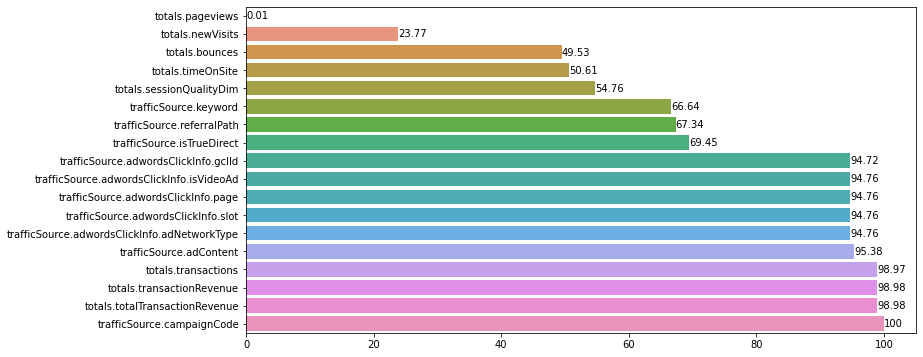

In [12]:
mis_val=train.isna().sum()
missing_val=round(mis_val[(mis_val>0)]/len(train)*100,2).sort_values()
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(missing_val,y=missing_val.index)
_ = ax.bar_label(ax.containers[0])

In [13]:
train['totals.newVisits'].value_counts()

1    91478
Name: totals.newVisits, dtype: int64

In [14]:
cons=[]
for i in cols:
    if train[i].nunique()==1:
        cons.append(i)
print(cons,sep=' ')

['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode']


In [15]:
y_train_ = train['totals.transactionRevenue']
y_train_.fillna(0, inplace = True)
y_train_.astype('float')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119995    0.0
119996    0.0
119997    0.0
119998    0.0
119999    0.0
Name: totals.transactionRevenue, Length: 120000, dtype: float64

In [16]:
for i in missing_val.index:
    if missing_val.loc[i]>48:
        train.drop(i,1,inplace=True)
    else:
        train[i].fillna('0', inplace = True)
        test[i].fillna('0', inplace = True)

In [17]:
for col in cons:
    if col not in missing_val.index:
        train.drop(col, axis = 1, inplace = True)

print('Number of columns in the training set',len(train.columns))

Number of columns in the training set 25


In [18]:
irrelavant = ['fullVisitorId', 'visitId', 'trafficSource.campaign']
for col in irrelavant:
    train.drop(col, axis = 1, inplace = True)

In [19]:
for df in [train, test]:
    print(df['visitStartTime'][0])
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['rec_dayofweek'] = df['visitStartTime'].dt.dayofweek
    df['rec_hours'] = df['visitStartTime'].dt.hour
    df['rec_dayofmonth'] = df['visitStartTime'].dt.day
    print(df['visitStartTime'][0], df['rec_dayofweek'][0], train['rec_hours'][0], df['rec_dayofmonth'][0])
    df.drop('visitStartTime', axis = 1, inplace = True)

1508198450
2017-10-17 00:00:50 1 0 17
1526099341
2018-05-12 04:29:01 5 0 12


In [20]:
le = LabelEncoder()
print('Columns that are converted to numerical values with label encodedr:')
for col in train.columns:
    if train[col].dtype == 'O':
        print(col)
        #print(col, train[col].unique())
        train.loc[:, col] = le.fit_transform(train.loc[:, col])
        test.loc[:, col] = le.fit_transform(test.loc[:, col])

Columns that are converted to numerical values with label encodedr:
channelGrouping
customDimensions
hits
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
totals.hits
totals.pageviews
totals.newVisits
trafficSource.source
trafficSource.medium


In [21]:
for col in train.columns:
    train[col] = train[col].astype('float')

In [22]:
fullvisitorid = []
for col in test.columns:
    if col == 'fullVisitorId':
        fullvisitorid = test[col] 
    if col not in train.columns:
        test.drop(col, axis = 1, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   channelGrouping           401589 non-null  int64
 1   customDimensions          401589 non-null  int64
 2   date                      401589 non-null  int64
 3   hits                      401589 non-null  int64
 4   visitNumber               401589 non-null  int64
 5   device.browser            401589 non-null  int64
 6   device.operatingSystem    401589 non-null  int64
 7   device.isMobile           401589 non-null  bool 
 8   device.deviceCategory     401589 non-null  int64
 9   geoNetwork.continent      401589 non-null  int64
 10  geoNetwork.subContinent   401589 non-null  int64
 11  geoNetwork.country        401589 non-null  int64
 12  geoNetwork.region         401589 non-null  int64
 13  geoNetwork.metro          401589 non-null  int64
 14  geoNetwork.city     

In [23]:
for col in test.columns:
    test[col] = test[col].astype('float')

In [24]:
model = lgb.LGBMRegressor(
        num_leaves = 31,  #(default = 31) – Maximum tree leaves for base learners.
        learning_rate = 0.03, #(default = 0.1) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using 
                              #reset_parameter callback. Note, that this will ignore the learning_rate argument in training.
        n_estimators = 1000, #(default = 100) – Number of boosted trees to fit.
        subsample = .9, #(default = 1.) – Subsample ratio of the training instance.
        colsample_bytree = .9, #(default = 1.) – Subsample ratio of columns when constructing each tree
        random_state = 34
)

In [25]:
train['date'].min(), train['date'].max()

(20160811.0, 20180429.0)

In [26]:
x_train = train[ train['date'] < 20171101 ]
x_valid = train[ train['date'] >= 20171101 ]
print('Number of samples in train set:', len(x_train))
print('Number of samples in validation set:',len(x_valid))

Number of samples in train set: 84825
Number of samples in validation set: 35175


In [27]:
y_train_len = len(x_train)
y_train = y_train_[:y_train_len]
y_valid = y_train_[y_train_len:]

In [28]:
x_train.drop('date', axis = 1, inplace = True)
x_valid.drop('date', axis = 1, inplace = True)

In [29]:
print(len(x_train), len(y_train))
print(len(x_valid), len(y_valid))

84825 84825
35175 35175


In [30]:
model.fit(
        x_train, np.log1p(y_train),
        eval_set = [(x_valid, np.log1p(y_valid))],
        early_stopping_rounds = 50,
        verbose = 100,
        eval_metric = 'rmse'
    )

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, n_estimators=1000,
              random_state=34, subsample=0.9)

In [31]:
feat_impr = pd.DataFrame()
feat_impr['feature'] = x_train.columns
feat_impr['importance'] = model.booster_.feature_importance(importance_type = 'gain')
feat_impr.sort_values(by = 'importance', ascending = False)[:10]

,feature,importance
22,rec_dayofmonth,2184.051979
2,hits,1370.217010
0,channelGrouping,1077.901001
20,rec_dayofweek,566.035995
5,device.operatingSystem,354.673996
16,totals.pageviews,265.623993
13,geoNetwork.city,192.095993
9,geoNetwork.subContinent,173.393005
14,geoNetwork.networkDomain,172.865005
21,rec_hours,135.039993


In [32]:
valid_preds = model.predict(x_valid, num_iteration = model.best_iteration_)
valid_preds[valid_preds < 0] = 0

In [33]:
mean_squared_error(np.log1p(y_valid), valid_preds)

3.032350405032811

In [34]:
pd.DataFrame(valid_preds,columns={'Valid_preds':'O'}).loc[35170:]

,Valid_preds
35170,0.185436
35171,0.185436
35172,0.185436
35173,0.185436
35174,0.185436


In [35]:
pickle.dump(model,open('model.pkl','wb'))